# Machine Learning for Virginia: COVID-19

# Data Preparation (1)

The following lines of code are courtesy Layne V. Berry

In [0]:
import numpy as np
import pandas as pd

FN = 'time_series_2019-ncov-Confirmed.csv' # input file name
OUT = '10DaysTimeSeries20March.csv' # output file name
DAYS = 10 # number of days to predict based on

In [0]:
full_dataset = [line.strip().split(',') for line in open(FN).readlines()]
days_total = len(full_dataset[0]) - 4
rows = (days_total - DAYS) * (len(full_dataset) - 1)
cols = ['Province/State', 'Country/Region', 'Lat', 'Long'] + [str(DAYS - i) + ' days prior' for i in range(DAYS)] + ['Cases']
new_dataset = pd.DataFrame(np.zeros((rows, len(cols))), columns=cols, dtype='object')

In [0]:
idx = 0
for region in range(len(full_dataset[1:])):
  region += 1
  for slc in range(days_total - DAYS):
    for i in range(4):
      new_dataset.at[idx, cols[i]] = full_dataset[region][i]
    for i in range(DAYS+1):
      new_dataset.at[idx, cols[4 + i]] = full_dataset[region][4 + slc + i]
    idx += 1
new_dataset.to_csv(OUT, index=False)

In [0]:
cases = pd.read_csv(OUT)

# Data Visualization

I don't like to run these cells before training my SVM/Logistic Models

In [0]:
cases

,Province/State,Country/Region,Lat,Long,10 days prior,9 days prior,8 days prior,7 days prior,6 days prior,5 days prior,4 days prior,3 days prior,2 days prior,1 days prior,Cases
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19
1,NaN,Thailand,15.0000,101.0000,3,5,7,8,8,14,14,14,19,19,19
2,NaN,Thailand,15.0000,101.0000,5,7,8,8,14,14,14,19,19,19,19
3,NaN,Thailand,15.0000,101.0000,7,8,8,14,14,14,19,19,19,19,25
4,NaN,Thailand,15.0000,101.0000,8,8,14,14,14,19,19,19,19,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22459,NaN,Nicaragua,12.8654,-85.2072,0,0,0,0,0,0,0,0,0,0,0
22460,NaN,Nicaragua,12.8654,-85.2072,0,0,0,0,0,0,0,0,0,0,0
22461,NaN,Nicaragua,12.8654,-85.2072,0,0,0,0,0,0,0,0,0,0,0
22462,NaN,Nicaragua,12.8654,-85.2072,0,0,0,0,0,0,0,0,0,0,0


In [0]:
cases.describe

<bound method NDFrame.describe of       Province/State Country/Region      Lat  ...  2 days prior  1 days prior  Cases
0                NaN       Thailand  15.0000  ...            14            19     19
1                NaN       Thailand  15.0000  ...            19            19     19
2                NaN       Thailand  15.0000  ...            19            19     19
3                NaN       Thailand  15.0000  ...            19            19     25
4                NaN       Thailand  15.0000  ...            19            25     25
...              ...            ...      ...  ...           ...           ...    ...
22459            NaN      Nicaragua  12.8654  ...             0             0      0
22460            NaN      Nicaragua  12.8654  ...             0             0      0
22461            NaN      Nicaragua  12.8654  ...             0             0      0
22462            NaN      Nicaragua  12.8654  ...             0             0      0
22463            NaN      Nicar

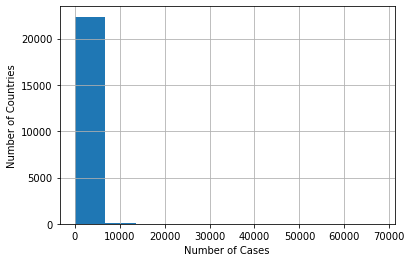

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
cases["Cases"].hist()
plt.xlabel('Number of Cases')
plt.ylabel('Number of Countries')
plt.show()

In [0]:
cases["lower"] = pd.cut(cases["Cases"],
                               bins=[0., 5, 20, 50, 100, 250, 500, 1000, np.inf],
                               labels=[1, 2, 3, 4, 5, 6, 7, 8])

In [0]:
cases["lower"].value_counts()

1    2268
2    1008
5     656
3     626
4     549
6     405
7     362
8     347
Name: lower, dtype: int64

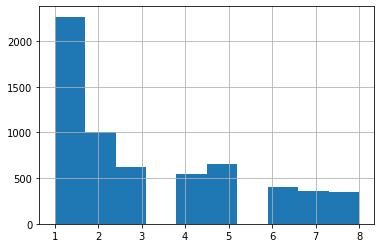

In [0]:
cases["lower"].hist()

In [0]:
cases.shape

(22464, 16)

# Data Preparation (2)

In [0]:
# cases.drop
# TimeSeriesSplit(max_train_size=None, n_splits=10)
# for train_index, test_index in TimeSeriesSplit.split(cases):
#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]

In [0]:
X_cases = cases.drop(["Cases", "Country/Region", "Province/State"], axis=1)
y_cases = cases["Cases"].copy()

In [0]:
X_cases

,Lat,Long,10 days prior,9 days prior,8 days prior,7 days prior,6 days prior,5 days prior,4 days prior,3 days prior,2 days prior,1 days prior,lower
0,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,2
1,15.0000,101.0000,3,5,7,8,8,14,14,14,19,19,2
2,15.0000,101.0000,5,7,8,8,14,14,14,19,19,19,2
3,15.0000,101.0000,7,8,8,14,14,14,19,19,19,19,3
4,15.0000,101.0000,8,8,14,14,14,19,19,19,19,25,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22459,12.8654,-85.2072,0,0,0,0,0,0,0,0,0,0,NaN
22460,12.8654,-85.2072,0,0,0,0,0,0,0,0,0,0,NaN
22461,12.8654,-85.2072,0,0,0,0,0,0,0,0,0,0,NaN
22462,12.8654,-85.2072,0,0,0,0,0,0,0,0,0,0,NaN


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_features = list(cases[["Lat", 
                           "Long", 
                          "10 days prior",
                          "9 days prior",
                          "8 days prior",
                          "7 days prior",
                          "6 days prior",
                          "5 days prior",
                          "4 days prior",
                          "3 days prior",
                          "2 days prior",
                          "1 days prior",]])
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),])


# I don't want to train these features. I think it'll lead to some bad overfitting.
"""cat_features = list(cases[["Country/Region", "Province/State",]])
cat_pipeline = Pipeline([('onehot', OneHotEncoder()),])
"""
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features),
        #("cat", cat_pipeline, cat_features),
    ])

X_cases = full_pipeline.fit_transform(X_cases)

We don't need to split the data at all. Since this is a time series, we use a different kind of validation called backtesting. 

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

Also, I don't think we should train based on "Country/Region" and "Province/State." Our model will 100% overfit to those variables since we only have so few rows of data for each country. Sometimes we have a lot (50 for the US), but in general we only have one row, and our model will overfit a lot.



In [0]:
a = X_cases[:,2:]+1
b = X_cases[:,0:2]

In [0]:
a = np.log10(a)

In [0]:
X_cases = np.append(b, a, axis=1)
X_cases

array([[ 15.        , 101.        ,   0.47712125, ...,   1.17609126,
          1.17609126,   1.30103   ],
       [ 15.        , 101.        ,   0.60205999, ...,   1.17609126,
          1.30103   ,   1.30103   ],
       [ 15.        , 101.        ,   0.77815125, ...,   1.30103   ,
          1.30103   ,   1.30103   ],
       ...,
       [ 12.8654    , -85.2072    ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 12.8654    , -85.2072    ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 12.8654    , -85.2072    ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [0]:
y_cases = y_cases+1
y_cases = np.log10(y_cases)

In [0]:
from sklearn.utils import shuffle

X_cases, y_cases = shuffle(X_cases, y_cases)

In [0]:
#For nets we want to create data splits
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X_cases, y_cases, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, random_state=42)

In [0]:
print((X_train.shape, y_train.shape), "\n", (X_test.shape, y_test.shape), "\n", (X_val.shape, y_val.shape))

((15275, 12), (15275,)) 
 ((4493, 12), (4493,)) 
 ((2696, 12), (2696,))


# Benchmarks


In [0]:
X_train[:,2:].mean()

0.3030606875046711

In [0]:
X_train[:,2:].std()

0.7186103630978793

#Preliminary Experiments

## SVM Trial


In [0]:
X_train[40:45]

array([[ 40.1431    ,  47.5769    ,   0.60205999,   0.84509804,
          0.84509804,   1.        ,   1.        ,   1.        ,
          1.07918125,   1.07918125,   1.07918125,   1.20411998],
       [ 41.5978    , -72.7554    ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ 31.0545    , -97.5635    ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ 35.1917    , 108.8701    ,   2.00860017,   2.06818586,
          2.11058971,   2.15533604,   2.22010809,   2.24054925,
          2.26717173,   2.29225607,   2.32014629,   2.33041377],
       [ 41.4277    , -85.355     ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

In [0]:
from sklearn.svm import SVR

clf_SVM = SVR(kernel='poly', degree=2).fit(X_train, y_train) # no hyper parameters because it is just a test

In [0]:
sample_data = X_val[:10]
sample_labels = y_val[:10]

clf_SVM.predict(sample_data)

array([0.09992441, 0.09997102, 0.10003286, 0.10018611, 0.2011171 ,
       0.10053581, 0.26135231, 0.09993017, 0.09992431, 1.19715064])

In [0]:
sample_labels

10785    0.000000
4534     0.000000
2510     0.000000
6241     0.000000
15970    1.301030
6517     0.000000
1131     0.477121
6068     0.000000
15326    0.000000
1387     2.053078
Name: Cases, dtype: float64

In [0]:
from sklearn.metrics import mean_squared_error

predictions = clf_SVM.predict(X_val)
svr_mse = mean_squared_error(y_val, predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

0.36674797585912544

In [0]:
svr_scores = cross_val_score(clf_SVM, X_val, y_val,
                         scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)

display_scores(svr_rmse_scores)

Scores: [0.47896939 0.45236114 0.5289942  0.34939939 0.50147016 0.3927249
 0.3841627  0.44061903 0.50353293 0.44824135]
Mean: 0.44804751964412903
Standard deviation: 0.05512556493089379


This is a super weird prediction and idk why this is. It should always give a value greater than the "1 days before" column...but it isn't...

## Linear Regression Trial

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
sample_data = X_val[:10]
sample_labels = y_val[:10]

print("Predictions:", lin_reg.predict(sample_data))

Predictions: [0.0103165  0.01101815 0.01498298 0.00466802 1.40214818 0.02046755
 0.52351458 0.00983118 0.0103315  2.0479331 ]


In [0]:
print("Labels:", list(sample_labels))

Labels: [0.0, 0.0, 0.0, 0.0, 1.3010299956639813, 0.0, 0.47712125471966244, 0.0, 0.0, 2.05307844348342]


In [0]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(X_val)
lin_mse = mean_squared_error(y_val, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.08008994480528397

In [0]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_scores = cross_val_score(lin_reg, X_val, y_val,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.06085275 0.11089643 0.05886205 0.06334483 0.10640909 0.06131177
 0.07509578 0.09954078 0.06783844 0.07779122]
Mean: 0.0781943124014946
Standard deviation: 0.019021501502303487


In [0]:
pd.Series(np.sqrt(-lin_scores)).describe()

count    10.000000
mean      0.078194
std       0.020050
min       0.058862
25%       0.061820
50%       0.071467
75%       0.094103
max       0.110896
dtype: float64

## ElasticNet Trial


In [0]:
from sklearn.linear_model import ElasticNetCV

net_reg = ElasticNetCV()
net_reg.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [0]:
sample_data = X_val[:10]
sample_labels = y_val[:10]

print("Predictions:", net_reg.predict(sample_data))

Predictions: [ 0.04437392  0.0560944   0.10156436 -0.0290701   0.95950715  0.16866484
  0.51569935  0.03842781  0.04455919  1.90986082]


In [0]:
print("Labels:", list(sample_labels))

Labels: [0.0, 0.0, 0.0, 0.0, 1.3010299956639813, 0.0, 0.47712125471966244, 0.0, 0.0, 2.05307844348342]


In [0]:
from sklearn.metrics import mean_squared_error

predictions = net_reg.predict(X_val)
net_mse = mean_squared_error(y_val, predictions)
net_rmse = np.sqrt(net_mse)
net_rmse

0.12950726858121847

In [0]:
net_scores = cross_val_score(net_reg, X_val, y_val,
                             scoring="neg_mean_squared_error", cv=10)
net_rmse_scores = np.sqrt(-net_scores)
display_scores(net_rmse_scores)

Scores: [0.14807236 0.14497224 0.12295196 0.10437547 0.16756071 0.10957079
 0.12597998 0.13811051 0.14013915 0.13095016]
Mean: 0.13326833381140493
Standard deviation: 0.01778779157130984


In [0]:
pd.Series(np.sqrt(-net_scores)).describe()

count    10.000000
mean      0.133268
std       0.018750
min       0.104375
25%       0.123709
50%       0.134530
75%       0.143764
max       0.167561
dtype: float64

## BayesianRidge Trial

In [0]:
from sklearn.linear_model import BayesianRidge

ridge_reg = BayesianRidge()
ridge_reg.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [0]:
sample_data = X_val[:10]
sample_labels = y_val[:10]

print("Predictions:", ridge_reg.predict(sample_data))

Predictions: [0.01032401 0.01102579 0.0149941  0.00467171 1.40204242 0.02048294
 0.523535   0.00983831 0.01033902 2.04786529]


In [0]:
print("Labels:", list(sample_labels))

Labels: [0.0, 0.0, 0.0, 0.0, 1.3010299956639813, 0.0, 0.47712125471966244, 0.0, 0.0, 2.05307844348342]


In [0]:
from sklearn.metrics import mean_squared_error

predictions = ridge_reg.predict(X_val)
ridge_mse = mean_squared_error(y_val, predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_rmse

0.08008720685732736

In [0]:
net_scores = cross_val_score(net_reg, X_val, y_val,
                             scoring="neg_mean_squared_error", cv=10)
net_rmse_scores = np.sqrt(-net_scores)
display_scores(net_rmse_scores)

Scores: [0.14807236 0.14497224 0.12295196 0.10437547 0.16756071 0.10957079
 0.12597998 0.13811051 0.14013915 0.13095016]
Mean: 0.13326833381140493
Standard deviation: 0.01778779157130984


In [0]:
pd.Series(np.sqrt(-net_scores)).describe()

count    10.000000
mean      0.133268
std       0.018750
min       0.104375
25%       0.123709
50%       0.134530
75%       0.143764
max       0.167561
dtype: float64

## Decision Tree Trial


In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [0]:
sample_data = X_val[:10]
sample_labels = y_val[:10]

print("Predictions:", tree_reg.predict(sample_data))

Predictions: [0.         0.01881437 0.         0.01835082 1.56820172 0.01114926
 0.77815125 0.02508583 0.01672389 2.04532298]


In [0]:
print("Labels:", list(sample_labels))

Labels: [0.0, 0.0, 0.0, 0.0, 1.3010299956639813, 0.0, 0.47712125471966244, 0.0, 0.0, 2.05307844348342]


In [0]:
predictions = tree_reg.predict(X_val)
tree_mse = mean_squared_error(y_val, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0982146553828329

In [0]:
tree_scores = cross_val_score(tree_reg, X_val, y_val,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

display_scores(tree_rmse_scores)

Scores: [0.0934091  0.1281962  0.10780534 0.06985569 0.11429665 0.07679447
 0.09182567 0.12360304 0.1105661  0.10445539]
Mean: 0.10208076381514206
Standard deviation: 0.018063996636669962


In [0]:
pd.Series(np.sqrt(-tree_scores)).describe()

count    10.000000
mean      0.102081
std       0.019041
min       0.069856
25%       0.092222
50%       0.106130
75%       0.113364
max       0.128196
dtype: float64

## Random Forest Trial


In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
sample_data = X_val[:10]
sample_labels = y_val[:10]

print("Predictions:", forest_reg.predict(sample_data))

Predictions: [0.         0.02151782 0.         0.02186024 1.46315086 0.01090982
 0.60450659 0.02462354 0.01544984 2.05878695]


In [0]:
print("Labels:", list(sample_labels))

Labels: [0.0, 0.0, 0.0, 0.0, 1.3010299956639813, 0.0, 0.47712125471966244, 0.0, 0.0, 2.05307844348342]


In [0]:
forest_predictions = forest_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.08386445702225481

In [0]:
forest_scores = cross_val_score(forest_reg, X_val, y_val,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [0.07413697 0.1164839  0.07214314 0.06280528 0.11070879 0.07338435
 0.08199477 0.10601922 0.08044441 0.09067862]
Mean: 0.08687994508729528
Standard deviation: 0.017411226001168064


In [0]:
pd.Series(np.sqrt(-forest_scores)).describe()

count    10.000000
mean      0.086880
std       0.018353
min       0.062805
25%       0.073573
50%       0.081220
75%       0.102184
max       0.116484
dtype: float64

##Recurrent Neural Net

In [0]:
print((X_train.shape, y_train.shape), "\n", (X_test.shape, y_test.shape), "\n", (X_val.shape, y_val.shape))

((15275, 12), (15275,)) 
 ((4493, 12), (4493,)) 
 ((2696, 12), (2696,))


In [0]:
import tensorflow as tf
from tensorflow.keras import layers
X_train_shaped = X_train.reshape(15275, 12, 1)
X_val_shaped = X_val.reshape(2696, 12, 1) 
X_test_shaped = X_test.reshape(4493, 12, 1)

model = tf.keras.Sequential()
model.add(layers.LSTM(5, input_shape=(12, 1)))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss="mean_squared_error",
              optimizer="sgd") # Accuracy wouldn't really tell us much

history = model.fit(X_train_shaped, y_train, validation_data=(X_val_shaped, y_val), batch_size=1, epochs=10)

Epoch 1/10
15275/15275 [==============================] - 53s 3ms/step - loss: 0.0203 - val_loss: 0.0083
Epoch 2/10
15275/15275 [==============================] - 52s 3ms/step - loss: 0.0103 - val_loss: 0.0071
Epoch 3/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 4/10
15275/15275 [==============================] - 53s 3ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 5/10
15275/15275 [==============================] - 58s 4ms/step - loss: 0.0095 - val_loss: 0.0065
Epoch 6/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0094 - val_loss: 0.0066
Epoch 7/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 8/10
15275/15275 [==============================] - 53s 3ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 9/10
15275/15275 [==============================] - 53s 3ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 10/10
15275/15275 [==============================

In [0]:
model.evaluate(X_test_shaped, y_test)

141/141 [==============================] - 0s 2ms/step - loss: 0.0081


0.008106366731226444

In [0]:
predictions = model.predict(X_test_shaped)

In [0]:
nn_mse = mean_squared_error(y_test, predictions)
nn_rmse = np.sqrt(nn_mse)
nn_rmse

0.09010842608532638

#Fine Tuning Models


##Random Forest

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=500),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
rnd_search.cv_results_

{'mean_fit_time': array([6.90462313, 3.52328758, 0.77344255, 0.27159734, 1.87922182,
        2.33762932, 4.89778609, 1.31453128, 1.61760325, 3.3399591 ]),
 'mean_score_time': array([0.20546861, 0.1331202 , 0.0393126 , 0.01095018, 0.05881801,
        0.11387386, 0.23421469, 0.05037427, 0.07701688, 0.12611666]),
 'mean_test_score': array([-0.00974665, -0.00976941, -0.01017376, -0.01008535, -0.00979653,
        -0.01005664, -0.01004926, -0.00982411, -0.01008218, -0.00977703]),
 'param_max_features': masked_array(data=[7, 5, 3, 5, 7, 3, 3, 5, 3, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[436, 271, 72, 21, 122, 215, 459, 100, 150, 258],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 7,

In [0]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=436, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
final_model = rnd_search.best_estimator_
final_predictions = final_model.predict(X_test)
final_predictions

array([0.        , 0.        , 0.        , ..., 1.94062816, 0.0155957 ,
       0.01175687])

In [0]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

0.09273428338958892

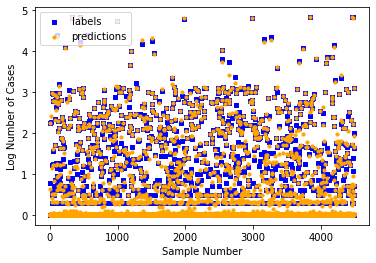

In [0]:
x = range(len(y_test))
fig = plt.figure()
ax1 = fig.add_subplot(111)


ax1.scatter(x, y_test, s=10, c='b', marker="s", label='labels')
ax1.scatter(x, final_predictions, s=10, c='orange', marker="o", label='predictions')
plt.legend(loc='upper left')
plt.xlabel("Sample Number")
plt.ylabel("Log Number of Cases")
plt.show()

##Recurrent Neural Net

In [0]:
final_model = tf.keras.Sequential()
final_model.add(layers.LSTM(10, input_shape=(12, 1)))
final_model.add(layers.Dense(1))

final_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [0]:
opt = tf.keras.optimizers.SGD(lr=.15, momentum=.3, nesterov=True, decay=.001)
final_model.compile(loss="mean_squared_error",
              optimizer=opt) # Accuracy wouldn't really tell us much

history = final_model.fit(X_train_shaped, y_train, validation_data=(X_val_shaped, y_val), batch_size=1, epochs=10)

Epoch 1/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0100 - val_loss: 0.0066
Epoch 2/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 3/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0091 - val_loss: 0.0064
Epoch 4/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0091 - val_loss: 0.0064
Epoch 5/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 6/10
15275/15275 [==============================] - 55s 4ms/step - loss: 0.0090 - val_loss: 0.0065
Epoch 7/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0090 - val_loss: 0.0065
Epoch 8/10
15275/15275 [==============================] - 55s 4ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 9/10
15275/15275 [==============================] - 54s 4ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 10/10
15275/15275 [==============================

In [0]:
final_model.evaluate(X_test_shaped, y_test)

141/141 [==============================] - 0s 2ms/step - loss: 0.0082


0.00815971102565527

In [0]:
predictions = final_model.predict(X_test_shaped)

In [0]:
nn_mse = mean_squared_error(y_test, predictions)
nn_rmse = np.sqrt(nn_mse)
nn_rmse

0.09040133536596712

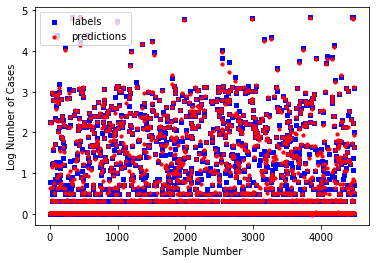

In [0]:
x = range(len(y_test))
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y_test, s=10, c='b', marker="s", label='labels')
ax1.scatter(x, predictions, s=10, c='r', marker="o", label='predictions')
plt.legend(loc='upper left')
plt.xlabel("Sample Number")
plt.ylabel("Log Number of Cases")
plt.show()

# Final Results


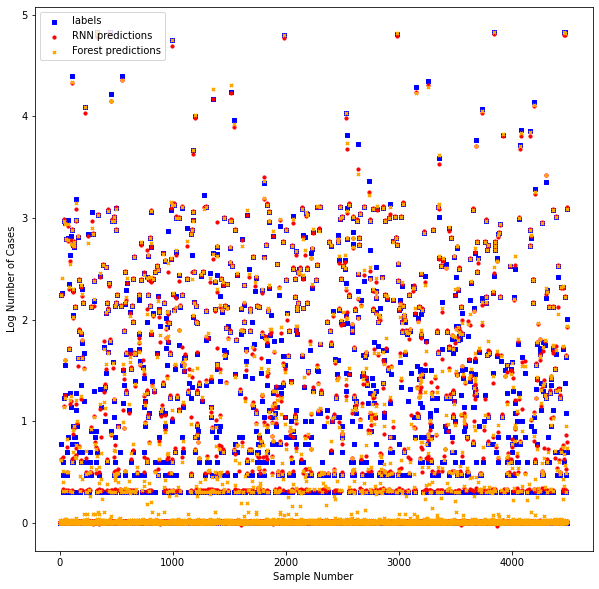

In [0]:
x = range(len(y_test))
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)

ax1.scatter(x, y_test, s=20, c='b', marker="s", label='labels')
ax1.scatter(x, predictions, s=10, c='r', marker="o", label='RNN predictions')
ax1.scatter(x, final_predictions, s=10, c='orange', marker="x", label='Forest predictions')
plt.legend(loc='upper left')
plt.xlabel("Sample Number")
plt.ylabel("Log Number of Cases")

plt.show()

We can better see the differences between the RNN and Forest predictions if we localize our graph to values above 1 and scale up the graph

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


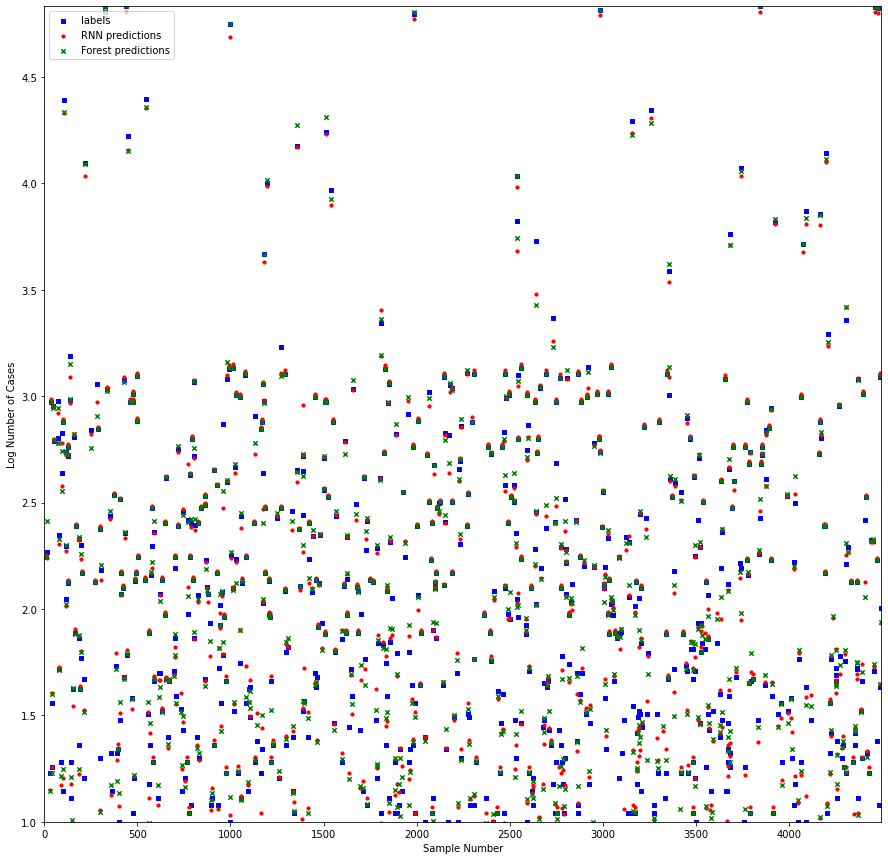

In [0]:
x = range(len(y_test))
fig = plt.figure(figsize=(15, 15),)
plt.axis([0, len(y_test), 1, max(y_test)])
ax1 = fig.add_subplot(111)

ax1.scatter(x, y_test, s=20, c='b', marker="s", label='labels')
ax1.scatter(x, predictions, s=10, c='r', marker="o", label='RNN predictions')
ax1.scatter(x, final_predictions, s=20, c='g', marker="x", label='Forest predictions')
plt.legend(loc='upper left')
plt.xlabel("Sample Number")
plt.ylabel("Log Number of Cases")

plt.show()

To further improve the visualization, we can sort values in ascending order to get a more linear-esque graph.

In [0]:
x = y_test.array
group = []
for i in range(len(x)):
  group.append((x[i], predictions[i][0], final_predictions[i]))
group[:10]

[(0.0, 0.013155341, 0.0),
 (0.0, 0.0131031275, 0.0),
 (0.0, 0.01305902, 0.0),
 (0.0, 0.013022065, 0.027136800063037696),
 (0.0, 0.013054252, 0.0),
 (0.7781512503836436, 0.62919533, 0.6218403011647011),
 (0.0, 0.013094068, 0.0),
 (0.0, 0.013156176, 0.017849733068824217),
 (0.0, 0.012941599, 0.0),
 (0.0, 0.013065934, 0.0)]

In [0]:
y = sorted(group)
y[:10], y[4480:]

([(0.0, -0.029879212, 0.006622789344579472),
  (0.0, -0.016505837, 0.0001842892468454048),
  (0.0, -0.014636517, 0.009379544042861093),
  (0.0, -0.011461735, 0.0024751863441459286),
  (0.0, -0.010167599, 4.602905132476777e-05),
  (0.0, -0.009794354, 0.0019110570988530075),
  (0.0, -0.005578518, 0.0),
  (0.0, -0.0028275251, 0.12702980797819488),
  (0.0, -0.0020228624, 0.0),
  (0.0, -0.0014013052, 0.0)],
 [(4.293716034826109, 4.237888, 4.22581589957061),
  (4.344647665919406, 4.3046994, 4.285211795174382),
  (4.393540107347963, 4.3317976, 4.336906120920482),
  (4.397140170748577, 4.353702, 4.358382687382206),
  (4.7501225267834, 4.6879625, 4.750039949517403),
  (4.7970111829532405, 4.7700467, 4.803116274852563),
  (4.806756388651972, 4.7824707, 4.8101534748133465),
  (4.814167656875621, 4.789414, 4.816064260078728),
  (4.825478048233257, 4.797922, 4.82448753309358),
  (4.828227964748957, 4.8029423, 4.8280622246856115),
  (4.830870836339318, 4.8064027, 4.830790803487879),
  (4.83106311831

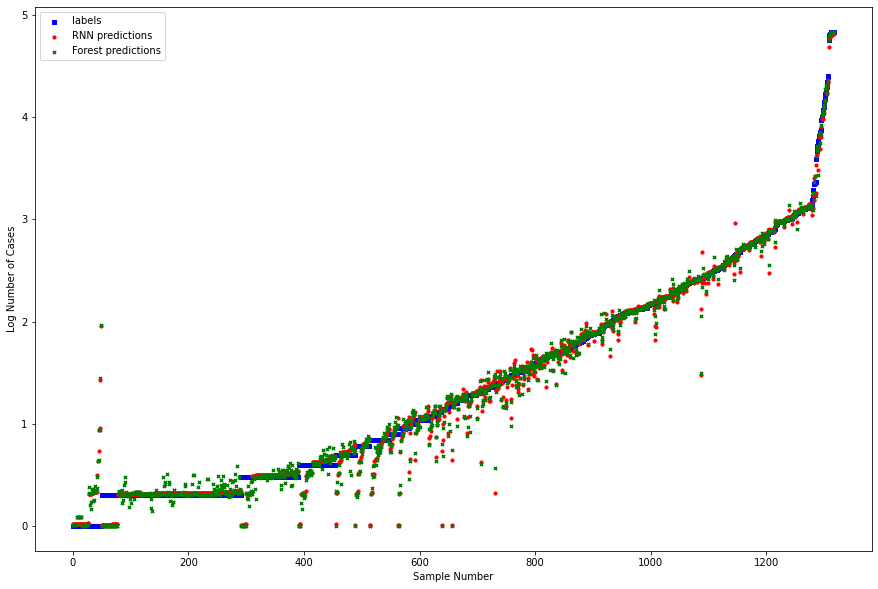

In [0]:
for i in range(len(y)):
  if y[i][0] > 0:
    break

x = range(len(y[i-50:]))
fig = plt.figure(figsize=(15, 10),)
# plt.axis([0, len(y_test), 1, max(y_test)])
ax1 = fig.add_subplot(111)
y = np.array(y)
ax1.scatter(x, y[i-50:,0], s=20, c='b', marker="s", label='labels')
ax1.scatter(x, y[i-50:,1], s=10, c='r', marker="o", label='RNN predictions')
ax1.scatter(x, y[i-50:,2], s=10, c='g', marker="x", label='Forest predictions')
plt.legend(loc='upper left')
plt.xlabel("Sample Number")
plt.ylabel("Log Number of Cases")

plt.show()

In [0]:
y[i-50: i]

array([[0.        , 0.02145052, 0.01126796],
       [0.        , 0.02145052, 0.01126796],
       [0.        , 0.02145052, 0.01126796],
       [0.        , 0.02145052, 0.01126796],
       [0.        , 0.02145052, 0.01126796],
       [0.        , 0.02145052, 0.01126796],
       [0.        , 0.02145052, 0.01126796],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.021451  , 0.08730622],
       [0.        , 0.02158463, 0.00316562],
       [0.        , 0.02162707, 0.00595053],
       [0.        , 0.02163899, 0.00439912],
       [0.        , 0.0247643 , 0.00899127],
       [0.        , 0.02481306, 0.0036345 ],
       [0.        , 0.02482665, 0.        ],
       [0.

We can see the errors across the data, but the way the data was sorted sets a certain pattern in the data. The sorted function sorts each element of the tuple when
the lower index elements are equal between two tuples. Therefore, when predictions are greater than expected, they will end up near the end of that segment of data, as seen in
values of expected 0. When predictions are less than expected, they will appear near the beginning of the segment.